In [25]:
import yaml
import torch

from roadvision3d.src.engine.model_builder import build_model
from roadvision3d.src.engine.model_saver import load_checkpoint
from roadvision3d.tools.inference import inference, process_image
from roadvision3d.src.datasets.object_3d import Calibration
from roadvision3d.visualization import Visualizer

from roadvision3d.src.datasets.kitti import KITTI

from roadvision3d.visualization import Visualizer_dataloader

from PIL import Image
import numpy as np
import os



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
config_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/configs/SMOKE_KITTI_EXP.yaml'

# load config
assert (os.path.exists(config_path))
cfg = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)

# build dataloader or load de data manually
dataset = KITTI(split='trainval', cfg=cfg['dataset'])

In [27]:
item = 8
inputs, calib, coord_range, targets, info = dataset.__getitem__(item)

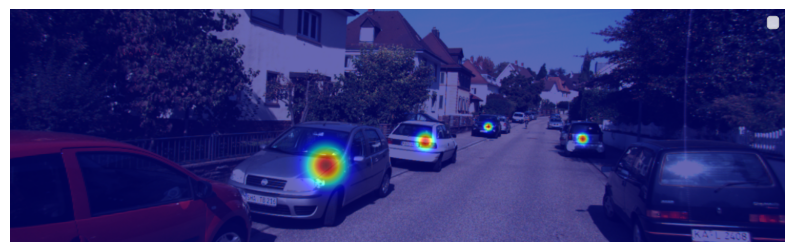

In [28]:
visualizer = Visualizer_dataloader(calib=calib, pitch=0.0, cfg=cfg['dataset'])
visualizer.draw_heatmaps(inputs, targets)

In [29]:

checkpoint_path = '/home/javier/pytorch/RoadVision3D/work_dirs/SMOKE_KITTI_EXP/logs/checkpoints/checkpoint_epoch_75.pth'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = build_model(cfg)
load_checkpoint(model = model,
                optimizer = None,
                filename = checkpoint_path,
                map_location=device)

75

In [30]:
img_path = '/home/javier/datasets/kitti/training/image_2/%06d.png' % item
calib_file = '/home/javier/datasets/kitti/training/calib/%06d.txt' % item

img_tensor, coord = process_image(img_path, cfg)
calib = Calibration.from_kitti_calib_file(calib_file)


results = inference(img_tensor, calib, model, cfg, device, coord)

In [31]:
import torch.nn.functional as F
import torch
def nms_hm(heatmap, pool_size=3):
    """Non-Maximum Suppression for heatmaps"""
    pad = (pool_size - 1) // 2
    hmax = F.max_pool2d(heatmap, (pool_size, pool_size), stride=1, padding=pad)
    keep = (hmax == heatmap).float()
    return heatmap * keep

def select_topk(heatmap, K=100):
    """Select top K scores and corresponding indices from the heatmap"""
    batch, cat, height, width = heatmap.size()
    heatmap = heatmap.view(batch, cat, -1)
    scores, indices = torch.topk(heatmap, K)
    clses = (indices / (height * width)).int()
    indices = indices % (height * width)
    ys = (indices / width).int().float()
    xs = (indices % width).int().float()
    # Adjust indices to be absolute indices in the batch
    indices = indices + (torch.arange(batch).view(batch, 1, 1) * height * width).type_as(indices)
    return scores.view(-1), indices.view(-1), clses.view(-1), ys.view(-1), xs.view(-1)

Results shape: torch.Size([1, 1, 96, 320])
torch.Size([1, 1, 96, 320])
tensor(0.9267, device='cuda:0', grad_fn=<SelectBackward0>) tensor(20611, device='cuda:0') tensor(0, device='cuda:0', dtype=torch.int32) tensor(64., device='cuda:0') tensor(131., device='cuda:0')


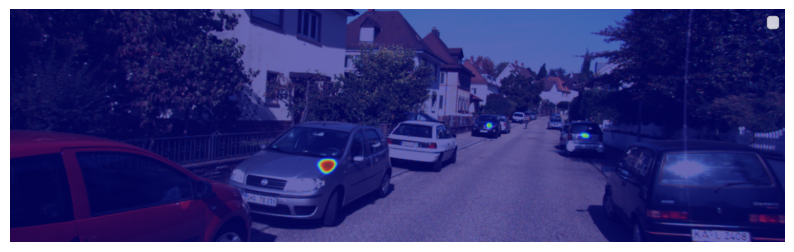

In [32]:
# Confirming the shape of the heatmap
print("Results shape:", results[0].shape)

# Extracting the heatmap for visualization
heatmap_raw = results[0][0].detach().cpu().numpy()  # [1, 1, 96, 320] -> [96, 320]

heatmap_nms = nms_hm(results[0])
print(heatmap_nms.shape)

scores, indices, clses, ys, xs = select_topk(heatmap_nms, K=50)
print(scores[0], indices[0], clses[0], ys[0], xs[0])

# Preparing the results dictionary
results_list = {
    'heatmap': heatmap_raw,
}
visualizer.draw_heatmaps(inputs, results_list)

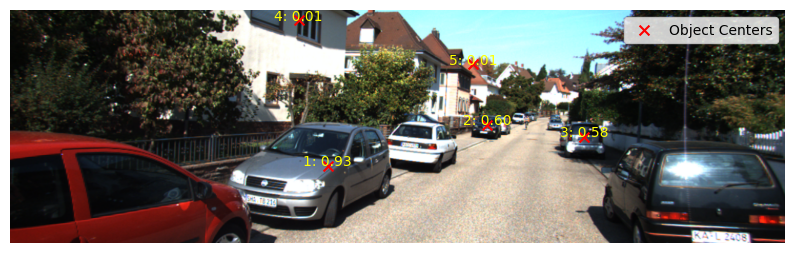

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def denormalize_image(inputs: np.ndarray) -> np.ndarray:
    """
    Denormalizes the input image tensor using the mean and std from cfg.

    Parameters:
    - inputs: Input image tensor (C, H, W).

    Returns:
    - img: Denormalized image as a NumPy array (H, W, C).
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = inputs.transpose(1, 2, 0)  # C, H, W -> H, W, C
    img = (img * std + mean) * 255  # Denormalize
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def draw_centers(
    inputs: np.ndarray,
    xs,
    ys,
    scores,
    num_centers: int = 4,
    downsample_factor: int = 4,
    save_path = None,
) -> None:
    """
    Visualize the first `num_centers` object centers overlaid on the image.

    Parameters:
    - inputs: Input image tensor of shape (C, H, W).
    - centers: List containing center information (scores, indices, classes, ys, xs).
    - num_centers: Number of centers to visualize.
    - downsample_factor: Factor by which the feature map is downsampled.
    - save_path: Optional path to save the visualized image.
    """
    # Denormalize the image if necessary
    img = denormalize_image(inputs)

    # Extract the first `num_centers` centers
    xs = xs[:num_centers].cpu().numpy()
    ys = ys[:num_centers].cpu().numpy()

    # Adjust coordinates back to input resolution
    centers_x = [x * downsample_factor for x in xs]
    centers_y = [y * downsample_factor for y in ys]

    # Plot the image with centers
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.scatter(centers_x, centers_y, c='red', s=50, marker='x', label='Object Centers')

    # Add labels for the first few centers (optional)
    for i, (x, y, score) in enumerate(zip(centers_x, centers_y, scores)):
        ax.text(
            x, y, f"{i+1}: {score:.2f}", color="yellow", fontsize=10, ha="center"
        )

    ax.legend()
    ax.axis('off')

    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close(fig)

draw_centers(inputs, xs, ys, scores, num_centers=5, downsample_factor=4)


In [34]:
depth_ref = (28.01, 16.32)
dim_ref = ((3.88, 1.63, 1.53))
device = "cuda:1"

# Test creation
depth_ref_tensor = torch.as_tensor(depth_ref).to(device=device)
dim_ref_tensor = torch.as_tensor(dim_ref).to(device=device)

print(depth_ref_tensor, dim_ref_tensor)
print(results[1].shape[0])

tensor([28.0100, 16.3200], device='cuda:1') tensor([3.8800, 1.6300, 1.5300], device='cuda:1')
1


In [38]:
from roadvision3d.src.models.losses.smoke_coder import SMOKECoder

smoke_coder = SMOKECoder(
    (28.01, 16.32),
    ((1.52563191, 1.6285674,  3.8831164),
    (1.78, 1.70, 0.58),
    (0.88, 1.73, 0.67)),
    'cuda:0',
)

def select_point_of_interest(batch_size, indices, pred_regression):
    """Select regression outputs corresponding to the top K points of interest"""
    # Flatten the regression outputs
    pred_regression_flat = pred_regression.view(batch_size, pred_regression.shape[1], -1)
    # Initialize a list to collect regression outputs
    pred_regression_pois = []
    for b in range(batch_size):
        # Get indices for the current batch
        batch_indices = indices[(indices // (pred_regression.shape[2] * pred_regression.shape[3])) == b]
        point_indices = batch_indices % (pred_regression.shape[2] * pred_regression.shape[3])
        # Get regression outputs at the selected points
        reg_pois = pred_regression_flat[b, :, point_indices].transpose(0, 1)
        pred_regression_pois.append(reg_pois)
    # Concatenate all regression outputs
    pred_regression_pois = torch.cat(pred_regression_pois, dim=0)
    return pred_regression_pois

# Select regression outputs at points of interest
pred_regression_pois = select_point_of_interest(results[1].shape[0], indices, results[1])
pred_regression_pois = pred_regression_pois.view(-1, 8)

# Decode the regression outputs
pred_proj_points = torch.cat([xs.view(-1, 1), ys.view(-1, 1)], dim=1)
pred_depths_offset = pred_regression_pois[:, 0]
pred_proj_offsets = pred_regression_pois[:, 1:3]
pred_dimensions_offsets = pred_regression_pois[:, 3:6]
pred_orientation = pred_regression_pois[:, 6:]

calib_P2_batch = torch.tensor(calib.P2, dtype=torch.float32).unsqueeze(0)

pred_depths = smoke_coder.decode_depth(pred_depths_offset)

pred_locations = smoke_coder.decode_location(
    pred_proj_points,
    pred_proj_offsets,
    pred_depths,
    calib_P2_batch,
    downsample_ratio=4  # Adjust based on your model
)

pred_dimensions = smoke_coder.decode_dimension(
    clses,
    pred_dimensions_offsets
)

# Adjust Y-coordinate of the locations
pred_locations[:, 1] += pred_dimensions[:, 1] / 2

pred_rotys, pred_alphas = smoke_coder.decode_orientation(
    pred_orientation,
    pred_locations
)
print(pred_locations[:3])
print(pred_dimensions[:3])
print(pred_rotys[:3])


tensor([[-1.0174,  2.2105,  6.9955],
        [ 7.2433,  2.1271, 31.8630],
        [ 9.2279,  2.4867, 20.9197]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[1.5105, 1.7364, 4.3136],
        [1.4574, 1.6047, 4.1274],
        [1.5098, 1.6354, 3.2127]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.9148,  1.9661, -1.2137], device='cuda:0', grad_fn=<SliceBackward0>)


In [42]:

max_detection = 50
threshold = 0.2

# Iterate over the batch to construct the final results
for i in range(results[1].shape[0]):
    preds = []
    for j in range(max_detection):
        score = scores[i * max_detection + j]
        if score < threshold:
            continue

        cls_id = clses[i * max_detection + j].item()

        # 2D bounding box decoding
        x, y = xs[i * max_detection + j], ys[i * max_detection + j]
        w, h = pred_proj_offsets[i * max_detection + j]

        bbox = [
            (x - w / 2).item() * 4,
            (y - h / 2).item() * 4,
            (x + w / 2).item() * 4,
            (y + h / 2).item() * 4,
        ]

        # Decode depth, dimensions, and positions
        depth = pred_depths[i * max_detection + j].item()
        dimensions = pred_dimensions[i * max_detection + j].tolist()
        alpha = 0.00
        ry = pred_rotys[i * max_detection + j].tolist()

        locations = pred_locations[i * max_detection + j].tolist()

        preds.append([cls_id, alpha] + bbox + dimensions + locations + [ry, score.item()])

print(preds)

[[0, 0.0, 533.6892700195312, 228.34507751464844, 514.3107299804688, 283.6549072265625, 1.5105172395706177, 1.7363673448562622, 4.313628196716309, -1.0173949003219604, 2.2105422019958496, 6.995458602905273, 1.9147964715957642, 0.9266570210456848], [0, 0.0, 795.2076416015625, 180.573974609375, 780.7923583984375, 195.426025390625, 1.4573520421981812, 1.6047039031982422, 4.127360820770264, 7.24334716796875, 2.1270623207092285, 31.863025665283203, 1.9660922288894653, 0.6009104251861572], [0, 0.0, 958.0821533203125, 196.79095458984375, 937.9178466796875, 219.20904541015625, 1.5098212957382202, 1.6354143619537354, 3.2126667499542236, 9.227864265441895, 2.4866762161254883, 20.91971778869629, -1.213733434677124, 0.5768967866897583]]
